# Analyze emerging SARS-CoV-2 Strains
[Work in progress]

This notebook queries the Knowledge Graph the most recently and frequently occuring strains.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from matplotlib.dates import MonthLocator, WeekdayLocator
import seaborn as sns
from py2neo import Graph

In [2]:
pd.options.display.max_rows = None  # display all rows
pd.options.display.max_columns = None  # display all columsns

##### Connect to COVID-19-Community Knowledge Graph

In [3]:
graph = Graph("bolt://132.249.238.185:7687", user="reader", password="demo")

##### Utility Methods

In [4]:
def transform_data(df, region):
    # calculate cummulatve sum
    df['total'] = df.groupby([region])['count'].cumsum()
    
    # pivot table
    df = pd.DataFrame(df.pivot(index='collectionDate', columns=region, values='total').to_records())
    df.fillna(method='ffill', inplace=True)
    
    # convert neo4j date to date
    df['collectionDate'] = df['collectionDate'].astype(str)
    df['collectionDate'] = pd.to_datetime(df['collectionDate'], infer_datetime_format=False)
    df.set_index('collectionDate', inplace=True)
    
    return df

In [5]:
def plot_time_series(df, title):
    plt.figure(figsize=(16, 10))
    ax = sns.lineplot(data=df);
    ax.set_title(title)
    ax.set_xlabel('Collection Date')
    ax.set_ylabel('Number of Strains')
    ax.set_yscale('log');
    ax.xaxis.set_major_locator(MonthLocator())
    ax.xaxis.set_minor_locator(WeekdayLocator())
    ax.tick_params(which='major', length=12)
    ax.tick_params(which='minor', length=8)
    ax.xaxis.grid(True, which='minor')
    ax.grid(True)

## Get the top 3 strains (lineages) in each country since a specified collection date

In [6]:
collection_date = '2020-12-01'
taxonomy_id = 'taxonomy:2697049' # SARS-CoV-2
host_taxonomy_id = 'taxonomy:9606' # human

In [7]:
query = """
// aggregate data to the country level (City->Admin2->Admin1->County): max 3 hops
MATCH (s:Strain)-[:FOUND_IN]->(:Location)-[:IN*0..3]->(c:Country)
WHERE s.taxonomyId = $taxonomy_id AND s.hostTaxonomyId = $host_taxonomy_id AND s.collectionDate > date($collection_date)
WITH DISTINCT s.lineage as lineage, count(s) as count, c.name as name
ORDER BY count DESC, name
RETURN DISTINCT name, COLLECT(lineage)[0] as lineage1, toString(COLLECT(count)[0]) as count1, 
                      COLLECT(lineage)[1] as lineage2, toString(COLLECT(count)[1]) as count2,
                      COLLECT(lineage)[2] as lineage3, toString(COLLECT(count)[2]) as count3
ORDER by name
"""
top3 = graph.run(query, taxonomy_id=taxonomy_id, host_taxonomy_id=host_taxonomy_id, collection_date=collection_date).to_data_frame()

In [8]:
top3.fillna('', inplace=True)
top3

,name,lineage1,count1,lineage2,count2,lineage3,count3
0,Argentina,P.2,4,,,,
1,Australia,B.1.348,157,B.1.1.7,28,B.1,27
2,Bangladesh,B.1.1.103,8,B.1.1.316,3,B.1.1.25,2
3,Belgium,B.1.1,126,B.1.221,43,B.1.160,32
4,Botswana,B.1.351,6,,,,
5,Brazil,B.1.1.28,15,P.1,11,P.2,8
6,Canada,B.1.36.17,6,B.1.1.7,5,B.1.1.1,1
7,China,B.1.1,14,B.1.1.171,1,,
8,Colombia,B.1.111,9,B.1.1,9,B.1,3
9,Czechia,B.1.258,3,B.1.177.12,1,,


## Emerging Strains Time Series by Country

Lineages for the UK (B.1.1.7), South Africa (B.1.351), and Brazil (B.1.1.28) strains

In [9]:
query = """
// aggregate data to the country level (City->Admin2->Admin1->County): max 3 hops
MATCH (s:Strain)-[:FOUND_IN]->(:Location)-[:IN*0..3]->(c:Country)
WHERE s.lineage = $lineage AND s.taxonomyId = $taxonomy_id
      AND s.collectionDate > date('2020-02-01') // remove strain with invalid collection date
WITH DISTINCT(s.collectionDate) AS collectionDate, c.name AS country, count(s) AS count
WHERE count >= $min_occurances
RETURN collectionDate, country, count
ORDER BY collectionDate
"""

### Time series for B.1.1.7 (UK) strain

In [10]:
lineage = 'B.1.1.7'
min_occurances = 5

In [11]:
df_country = graph.run(query, lineage=lineage, min_occurances=min_occurances, taxonomy_id=taxonomy_id).to_data_frame()

In [12]:
df_country = transform_data(df_country, 'country')

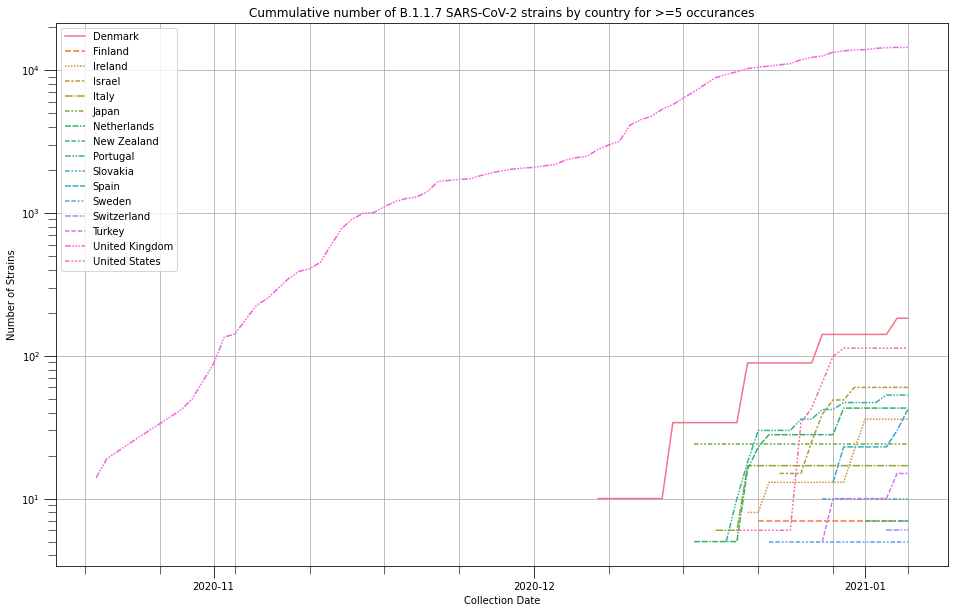

In [13]:
plot_time_series(df_country, f'Cummulative number of {lineage} SARS-CoV-2 strains by country for >={min_occurances} occurances')

### Time series for B.1.351 (South Africa) strain

In [14]:
lineage = 'B.1.351'
min_occurances = 1

In [15]:
df_country = graph.run(query, lineage=lineage,  min_occurances=min_occurances, taxonomy_id=taxonomy_id).to_data_frame()

In [16]:
df_country = transform_data(df_country, 'country')

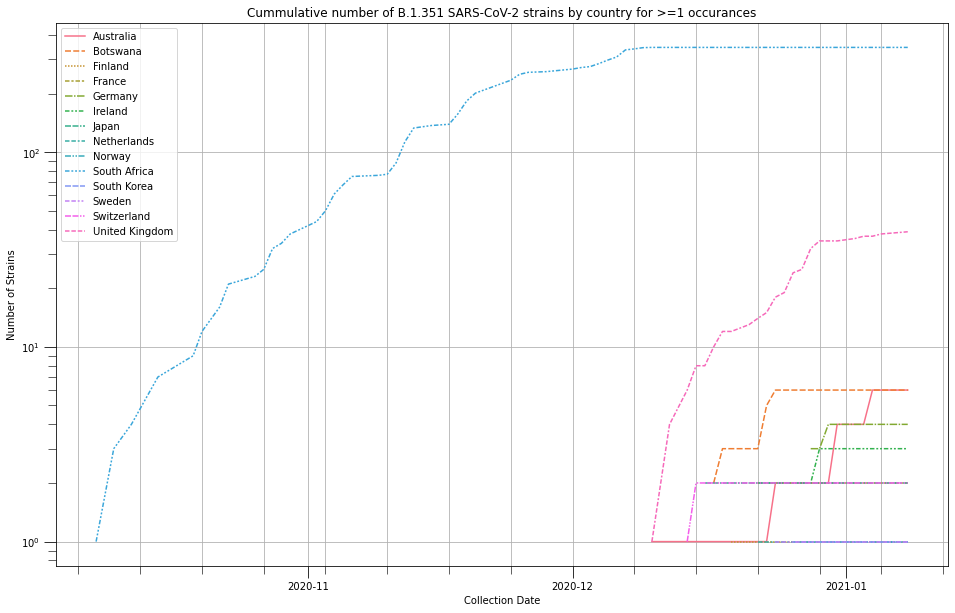

In [17]:
plot_time_series(df_country, f'Cummulative number of {lineage} SARS-CoV-2 strains by country for >={min_occurances} occurances')

### Time series for B.1.1.28 (Brazil) strain

In [18]:
lineage = 'B.1.1.28'
min_occurances = 1

In [19]:
df_country = graph.run(query, lineage=lineage,  min_occurances=min_occurances, taxonomy_id=taxonomy_id).to_data_frame()

In [20]:
df_country = transform_data(df_country, 'country')

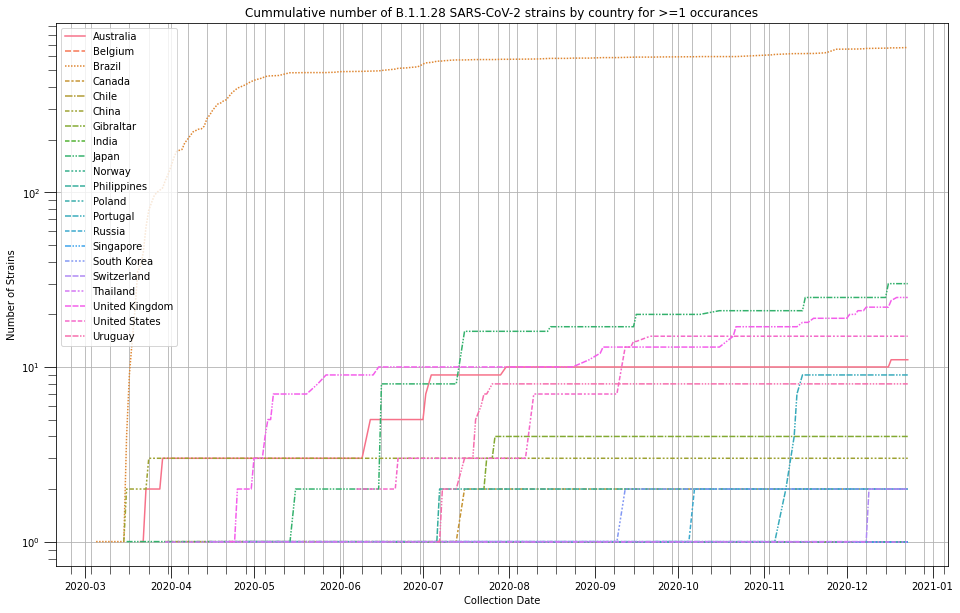

In [21]:
plot_time_series(df_country, f'Cummulative number of {lineage} SARS-CoV-2 strains by country for >={min_occurances} occurances')